In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/20192.ai4eng/master/init.py
import init; init.init(force_download=False); init.get_weblink()

# 1. Un modelo para datos (distribuciones) 1D

**Caso ideal**: Sabemos las distribuciones de las que vienen los datos. $\Rightarrow$ podemos calcular analíticamente nuestro modelo.

- ¿Podemos encontrar un modelo con 100% de acierto? ¿Por qué sí, o por qué no?


In [29]:
from local.lib import mlutils

from scipy import stats
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


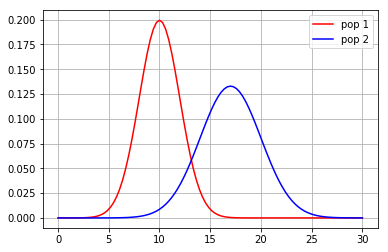

In [2]:
## KEEPOUTPUT
d1 = stats.norm(loc=10,scale=2)
d2 = stats.norm(loc=17,scale=3)


x = np.linspace(0,30,100)
plt.plot(x, d1.pdf(x), color="red", label="pop 1")
plt.plot(x, d2.pdf(x), color="blue", label="pop 2")
plt.grid()
plt.legend();

frontera óptima en 13.15


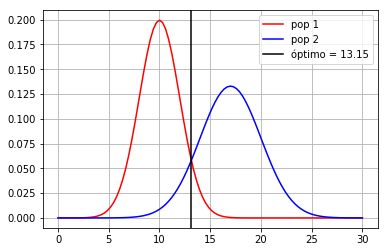

In [3]:
## KEEPOUTPUT
x = np.linspace(5,25,1000)
minx = x[np.argmin(np.abs(d1.pdf(x)-d2.pdf(x)))]

print("frontera óptima en %.2f"%minx)

x = np.linspace(0,30,100)
plt.plot(x, d1.pdf(x), color="red", label="pop 1")
plt.plot(x, d2.pdf(x), color="blue", label="pop 2")
plt.axvline(minx, color="black", label="óptimo = %.2f"%minx)
plt.grid()
plt.legend();

#### cálculo analítico de los errores de clasificación

In [4]:
## KEEPOUTPUT
print("pop 1 error", 1-d1.cdf(minx))
print("pop 2 error", d2.cdf(minx))

pop 1 error 0.05773516274534907
pop 2 error 0.09957961739117976


**Caso real**: Tenemos una muestra de los datos 

$\rightarrow$ ¿Cómo determinamos donde poner la frontera?

$\rightarrow$ ¿Qué frontera qusiéramos obtener?

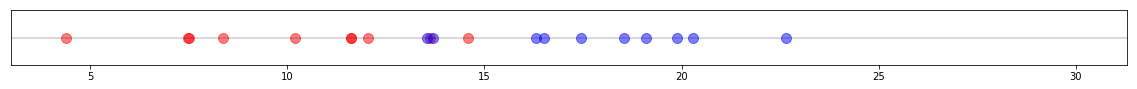

In [15]:
## KEEPOUTPUT
from local.lib import mlutils
mlutils.show_1D_dataset_samples(10, d1, d2, n_datasets=1, dot_alpha=.5, line_alpha=0, figsize=(20,1))
plt.axis("on"); plt.ylim(.095, .105); plt.yticks([]); 
plt.axhline(.1, color="black", alpha=.2)

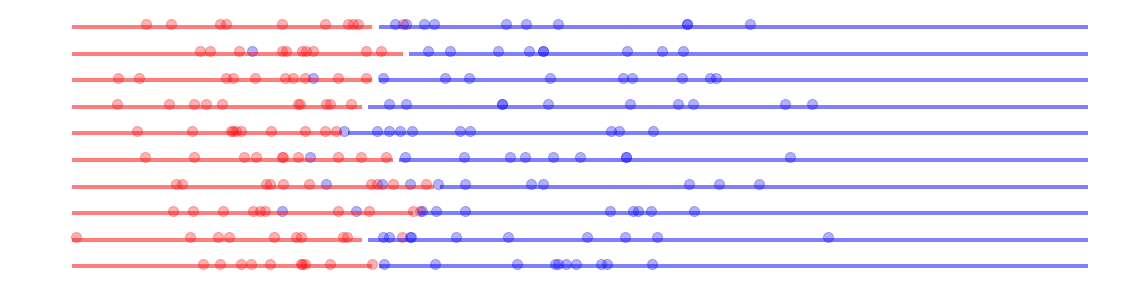

In [10]:
## KEEPOUTPUT
mlutils.show_1D_dataset_samples(10, d1, d2, dot_alpha=.3)

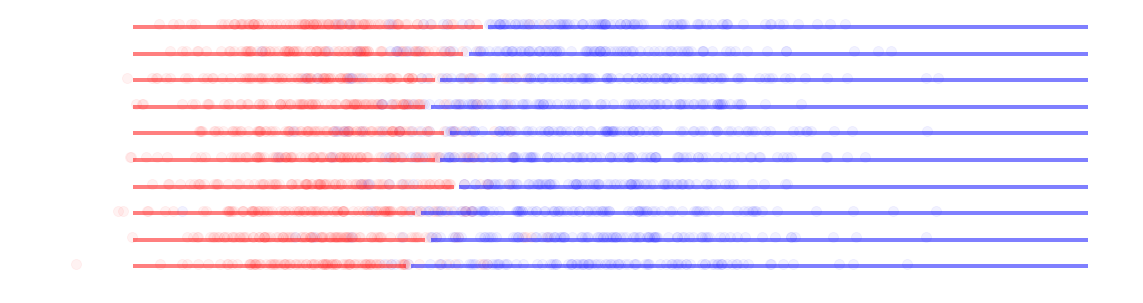

In [11]:
## KEEPOUTPUT
mlutils.show_1D_dataset_samples(100, d1, d2, dot_alpha=.05)

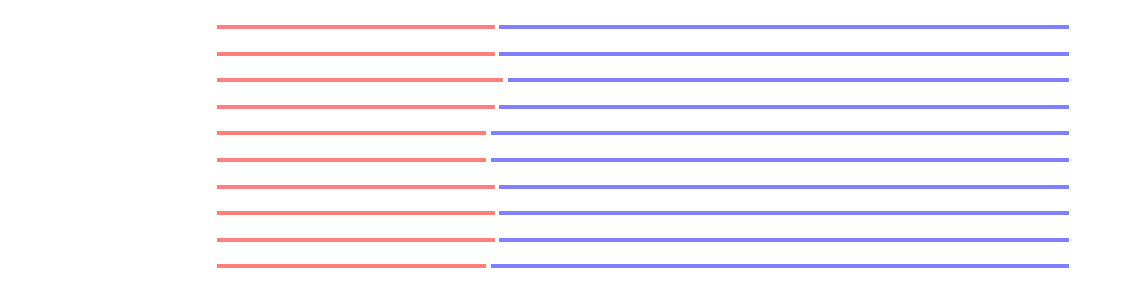

In [12]:
## KEEPOUTPUT
mlutils.show_1D_dataset_samples(10000, d1, d2, dot_alpha=.001)

# 2. Un modelo para datos (distribuciones) 2D

- en 2D, un modelo de clasificación **es una frontera** en el plano

- **supongamos** que tenemos acceso a las distribuciones de las que surgen los datos $\rightarrow$ podemos muestrear tantas veces como queramos

- ¿cuál es la frontera que produce menos error de clasificación?

- $\epsilon$ es el error de clasificación calculado analíticamente **con la frontera óptima** porque conocemos las distribuciones que generan los datos.
- $\hat{\epsilon}$ es el error de clasificacón calculado con la muestra de datos y **con la frontera óptima** (conocida también como _frontera bayesiana_).

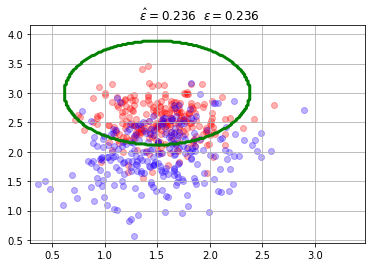

In [23]:
## KEEPOUTPUT
mc = mlutils.Example_Bayes2DClassifier(mean0=[1.5, 2.5], cov0=[[0.1, 0.], [0., 0.1]],
                                        mean1=[1.5, 2.], cov1=[[0.2,0.1],[0,.2]])
X,y = mc.sample(500)
mlutils.plot_2Ddata_with_boundary(mc.predict, X, y, line_width=3, line_color="green", dots_alpha=.3)
plt.title(" $\hat{\epsilon}=%.3f$"%(1-mc.score(X,y))+"  $\epsilon=%.3f$"%(1-mc.analytic_score()));
plt.grid();

haz los siguientes experimentos:

- separa los centros de las distribuciones de cada clase (`mean0`, `mean1`).
- aumenta y disminuye las matrices de covarianza.
- aumenta y disminuye el número de muestras.


- observa la estabilidad de $\hat{\epsilon}$ respecto a $\epsilon$ según ambas clases están más mezcladas o hay más o menos datos.

en general **SOLO TENEMOS UNA MUESTRA** de los datos, porque no tenemos conocimiento de las distribuciones que los generan. Los métodos de **estadística** y de **machine learning** están diseñados para esta situación.

Ejecuta la siguiente celda y pregúntate cada vez, **¿qué frontera establecerías con los datos que ves?**.

Fíjate que tenemos distintas muestras de una misma disitribución de base. Es decir, **la realidad detrás de estos datos siempre es la misma**.

**Aumenta** el número de muestras y hazte cada vez la misma pregunta.

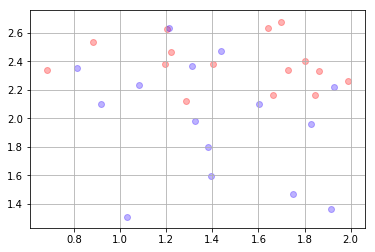

In [24]:
## KEEPOUTPUT
X,y = mc.sample(30)
mlutils.plot_2Ddata(X, y, dots_alpha=.3)
plt.grid()

### Los algoritmos de machine learning:

- Los algoritmos de clasificación **calculan fronteras** entre los datos.
- Parten de una muestra de los datos, **no de las distribuciones**.
- Por tanto, **no conocemos** la forma de la frontera bayesiana.

O sea, **partimos ciegos**!!!!!!!

Para abordar esta situación, **cualquier algoritmo** tiene necesariamente que plantear una alguna suposición de base:

- los datos vienen de distribuciones normales.
- las columnas son estadísticamente independientes.
- la frontera es lineal, o cuadrática.
- la frontera se representa con una red neuronal.

Teniendo esto en cuenta, y **partiendo de una muestra de los datos**:

- el objetivo de un usuario de ML es acercarse lo más posible a la **frontera bayesiana** (que no sabemos cómo es).
- distintos algoritmos ML tienen **distintas capacidades** para modelar fronteras (un clasificador lineal no puede captuarar una frontera cuadrática).
- necesitamos dos tipos de herramientas:
   - una buena colección de algoritmos ML.
   - métodos para saber qué tan cerca estamos de la frontera bayesiana.

### observa cómo un clasificador lineal aproxima la frontera con diferentes tamaños de muestras

- cambia el parámetro `n_samples` y experimenta con el siguiente código.
- usa luego estimadores distintos. P.ej.

        estimator = SVC(gamma=1)
        estimator = RandomForestClassifier()
        estimator = SVC(gamma=100)
        
Hazte las siguientes preguntas:

- ¿qué complejidad es capaz de capturar un estimador?

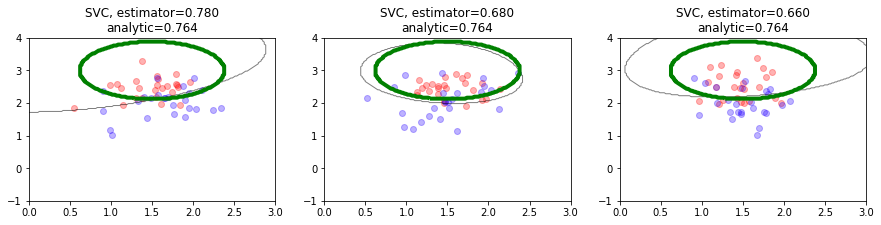

In [30]:
## KEEPOUTPUT
n_samples = 50
estimator = LogisticRegression()
estimator = SVC(gamma=.5)
plt.figure(figsize=(15,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    mlutils.plot_estimator_border(mc, estimator, mins=[0,-1], maxs=[3,4], n_samples=n_samples, legend=False)

hacemos ahora el experimento más exhaustivo repitiendo 20 veces el siguiente proceso:

- se muestrea el dataset (recuerda que **excepcionalmente** tenemos acceso a las distribuciones que generan los datos y por tanto podemos hacer esto).
- se calcula la fronter de clasificación obtenida por el estimador usando el dataset muestreado.
- se pinta esta frontera (en negro).
- en verde se muestra la **frontera bayesiana**.

100% (4 of 4) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05


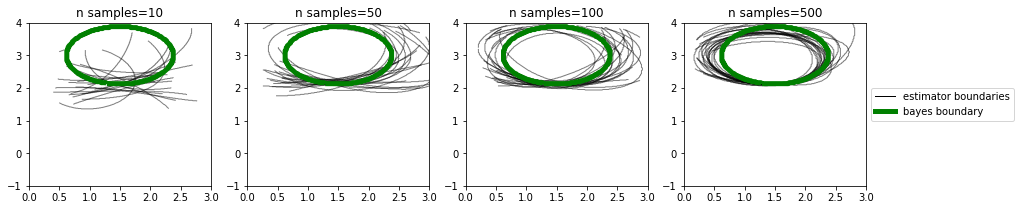

In [31]:
## KEEPOUTPUT
mlutils.sample_borders(mc, estimator, samples = [10,50,100,500], n_reps=20, mins=[0,-1], maxs=[3,4])

---
# 3. Solo tenemos un dataset
---

- remuestrea, reentrena para medir el desempeño y entender la estabilidad
- prueba con `test_pct` entre 0.1 y 0.9. observa la divergencia entre train y test cuando `test_pct` es más cercano a 0.9. ¿por qué?
- prueba con `SVC(gamma=100)`. En este caso observa la divergencia entre train y test incluso cuando `test_pct` es pequeño. ¿por qué?
- prubea además con `dataset_size` entre 20 y 500

Entiende la diferencia entre **tener pocos datos** y **overfitting**

Configuraciones interesantes sobre 

    mc = mlutils.Example_Bayes2DClassifier(mean0=[1.5, 1.5], cov0=[[0.5, 0.1], [0.3, 0.5]],
                                            mean1=[1.2, 2.], cov1=[[0.2,0.1],[0,.5]])

- SVC $\gamma=100$, `dataset_size=500` (overfitting con pocos datos, convergencia con muchos)
- SVC $\gamma=100$, `dataset_size=2000` (overfitting con pocos datos, convergencia con muchos)
- SVC $\gamma=.01$, `dataset_size=100` (variabilidad siempre, convergencia promedio con pocos datos)
- SVC $\gamma=1$, `dataset_size=100` (variabilidad siempre, convergencia promedio con pocos datos)
- LinearRegression, `dataset_size=100` (nunca converge a la frontera bayesiana)



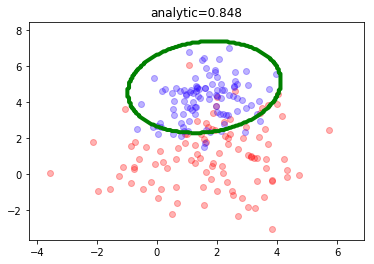

In [32]:
## KEEPOUTPUT
dataset_size = 200
mc = mlutils.Example_Bayes2DClassifier(mean0=[1.5, 1.5], cov0=[[4., 0.5], [0.1, 4.]],
                                        mean1=[1.5,4.], cov1=[[1,0.5],[0.1,1.]])
X,y = mc.sample(dataset_size)
mlutils.plot_estimator_border(mc, n_samples=dataset_size, legend=False)
analitic_score = mc.analytic_score()

realizamos un muestreo para dividir entre train y test

In [33]:
## KEEPOUTPUT
test_pct = .3
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_pct)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(140, 2) (140,)
(60, 2) (60,)


Text(0.5, 1.0, 'test data')

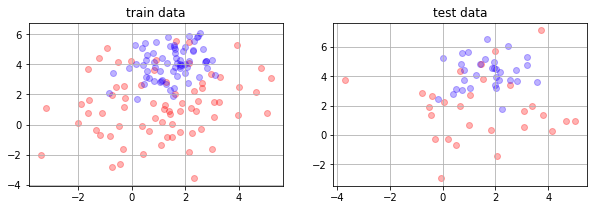

In [34]:
## KEEPOUTPUT
plt.figure(figsize=(10,3))
plt.subplot(121)
mlutils.plot_2Ddata(X_train, y_train, dots_alpha=.3)
plt.title("train data")
plt.grid()
plt.subplot(122)
mlutils.plot_2Ddata(X_test, y_test, dots_alpha=.3)
plt.grid()
plt.title("test data")

In [35]:
#estimator = SVC(gamma=1)
estimator = SVC(gamma=100)
#estimator = LogisticRegression()
#estimator = RandomForestClassifier()
estimator.fit(X_train, y_train)

In [37]:
## KEEPOUTPUT
print("accuracy train %.2f"%estimator.score(X_train,y_train))
tr_preds = estimator.predict(X_train)
print("predicciones para train")
print(tr_preds)
print("ground truth para train")
print(y_train)

accuracy train 1.00
predicciones para train
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
ground truth para train
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]


In [38]:
## KEEPOUTPUT
print("\naccuracy test %.2f"%estimator.score(X_test,y_test))
ts_preds = estimator.predict(X_test)
print("predicciones para test")
print(ts_preds)
print("ground truth para test")
print(y_test)


accuracy test 0.65
predicciones para test
[1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
ground truth para test
[1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.]


train_score  1.00
test_score   0.58


(0.853175, 0.146825)

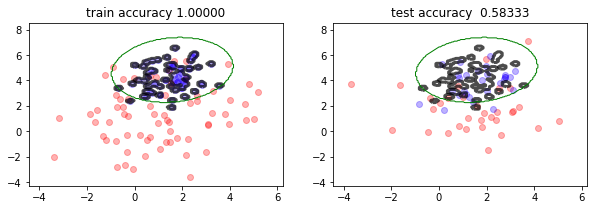

In [39]:
## KEEPOUTPUT
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_pct)
estimator.fit(X_train, y_train)
trsc = estimator.score(X_train, y_train)
tssc = estimator.score(X_test, y_test)
print("train_score %5.2f"%estimator.score(X_train, y_train))
print("test_score  %5.2f"%estimator.score(X_test, y_test))

plt.figure(figsize=(10,3))
plt.subplot(121)
mlutils.plot_2Ddata(X_train, y_train, dots_alpha=.3)
mlutils.plot_2D_boundary(estimator.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=3, line_alpha=.7, label=None)
plt.title("train accuracy %.5f"%estimator.score(X_train, y_train))

mlutils.plot_2D_boundary(mc.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=1, line_alpha=1., line_color="green", label="bayes boundary")

plt.subplot(122)
mlutils.plot_2Ddata(X_test, y_test, dots_alpha=.3)
mlutils.plot_2D_boundary(estimator.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=3, line_alpha=.7, label=None)
plt.title("test accuracy  %.5f"%estimator.score(X_test, y_test))
mlutils.plot_2D_boundary(mc.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=1, line_alpha=1., line_color="green", label="bayes boundary")

# 4. Learning curves

normalmente tenemos datasets de muchas dimensiones (columnas) y no podemos visualizar los datos como en 2D $\rightarrow$ necesitamos métodos para recabar evidencia sobre si tenemos pocos datos, estamos haciendo overfitting, etc.

Las **curvas de aprendizaje** nos ayudan a esto.

Realiza el experimento desde la sección anterior, con distintos tamaños del dataset inicial y con distintos algoritmos.

In [57]:
X,y = mc.sample(500)

100% (9 of 9) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


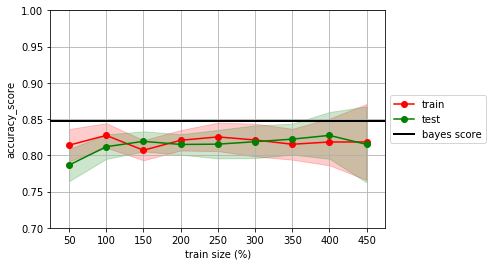

In [58]:
## KEEPOUTPUT
estimator = LogisticRegression()
mlutils.lcurve(estimator, X, y, n_reps=20, score_func=accuracy_score)
plt.axhline(analitic_score, lw=2, color="black", label="bayes score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.7,1.0);

100% (9 of 9) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


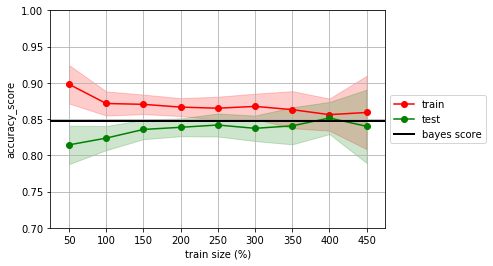

In [59]:
## KEEPOUTPUT
estimator = SVC(gamma=1)
mlutils.lcurve(estimator, X, y, n_reps=20, score_func=accuracy_score)
plt.axhline(analitic_score, lw=2, color="black", label="bayes score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.7,1.0);

100% (9 of 9) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


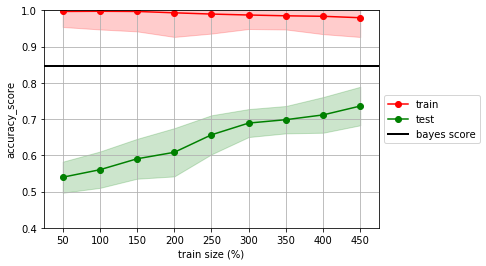

In [60]:
## KEEPOUTPUT
estimator = SVC(gamma=100)
mlutils.lcurve(estimator, X, y, n_reps=20, score_func=accuracy_score)
plt.axhline(analitic_score, lw=2, color="black", label="bayes score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.4,1.0);

no olvides que normalmente **no conocemos la _frontera bayesiana_**, y por tanto no tenemos el _bayes score_

## Taxonomía de problemas de machine learning

- Supervisados
   - Clasificación
   - Regresión
- No supervisados
   - Agrupamiento
   - Estimación de densidad
   - etc.
- Reinforcement learning


## Complejidad de los modelos vs. complejidad de los datos

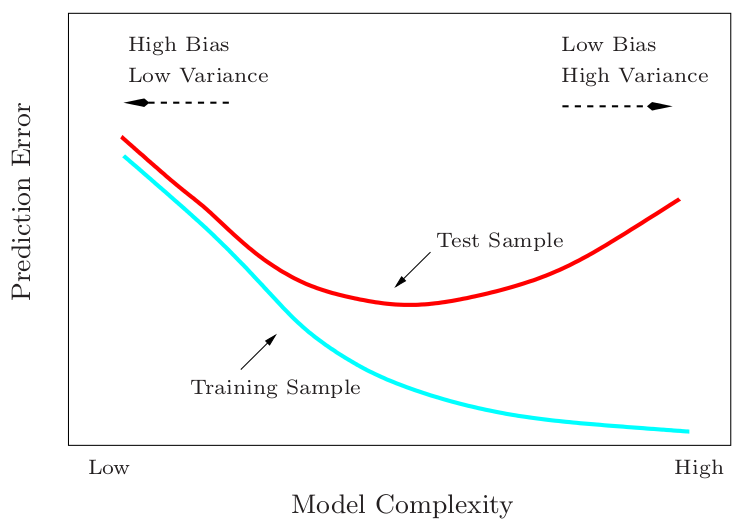

In [29]:
Image(filename='local/imgs/bvc.png', width=600)